<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Distribution-of-Features" data-toc-modified-id="Distribution-of-Features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Distribution of Features</a></span></li><li><span><a href="#Feature-Scaling" data-toc-modified-id="Feature-Scaling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Scaling</a></span></li><li><span><a href="#LASSO-Regression" data-toc-modified-id="LASSO-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LASSO Regression</a></span></li><li><span><a href="#Principal-Component-and-Forward-Selection" data-toc-modified-id="Principal-Component-and-Forward-Selection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Principal Component and Forward Selection</a></span></li></ul></div>

# Regression - Assignment 3

Data and Package Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt

In [2]:
df = pd.read_excel('data/impurity_dataset-training.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True
    
all_data = df[df.columns[1:]].values
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis = 1).copy().values
X = np.array(all_data[real_rows, :-5], dtype = 'float')
y = np.array(all_data[real_rows, -3], dtype = 'float')
y = y.reshape(-1, 1)

print('X matrix dimensions: {}'.format(X.shape))
print('y matrix dimensions: {}'.format(y.shape))

X matrix dimensions: (10297, 40)
y matrix dimensions: (10297, 1)


## Distribution of Features

**Plot histograms of all 40 features.**

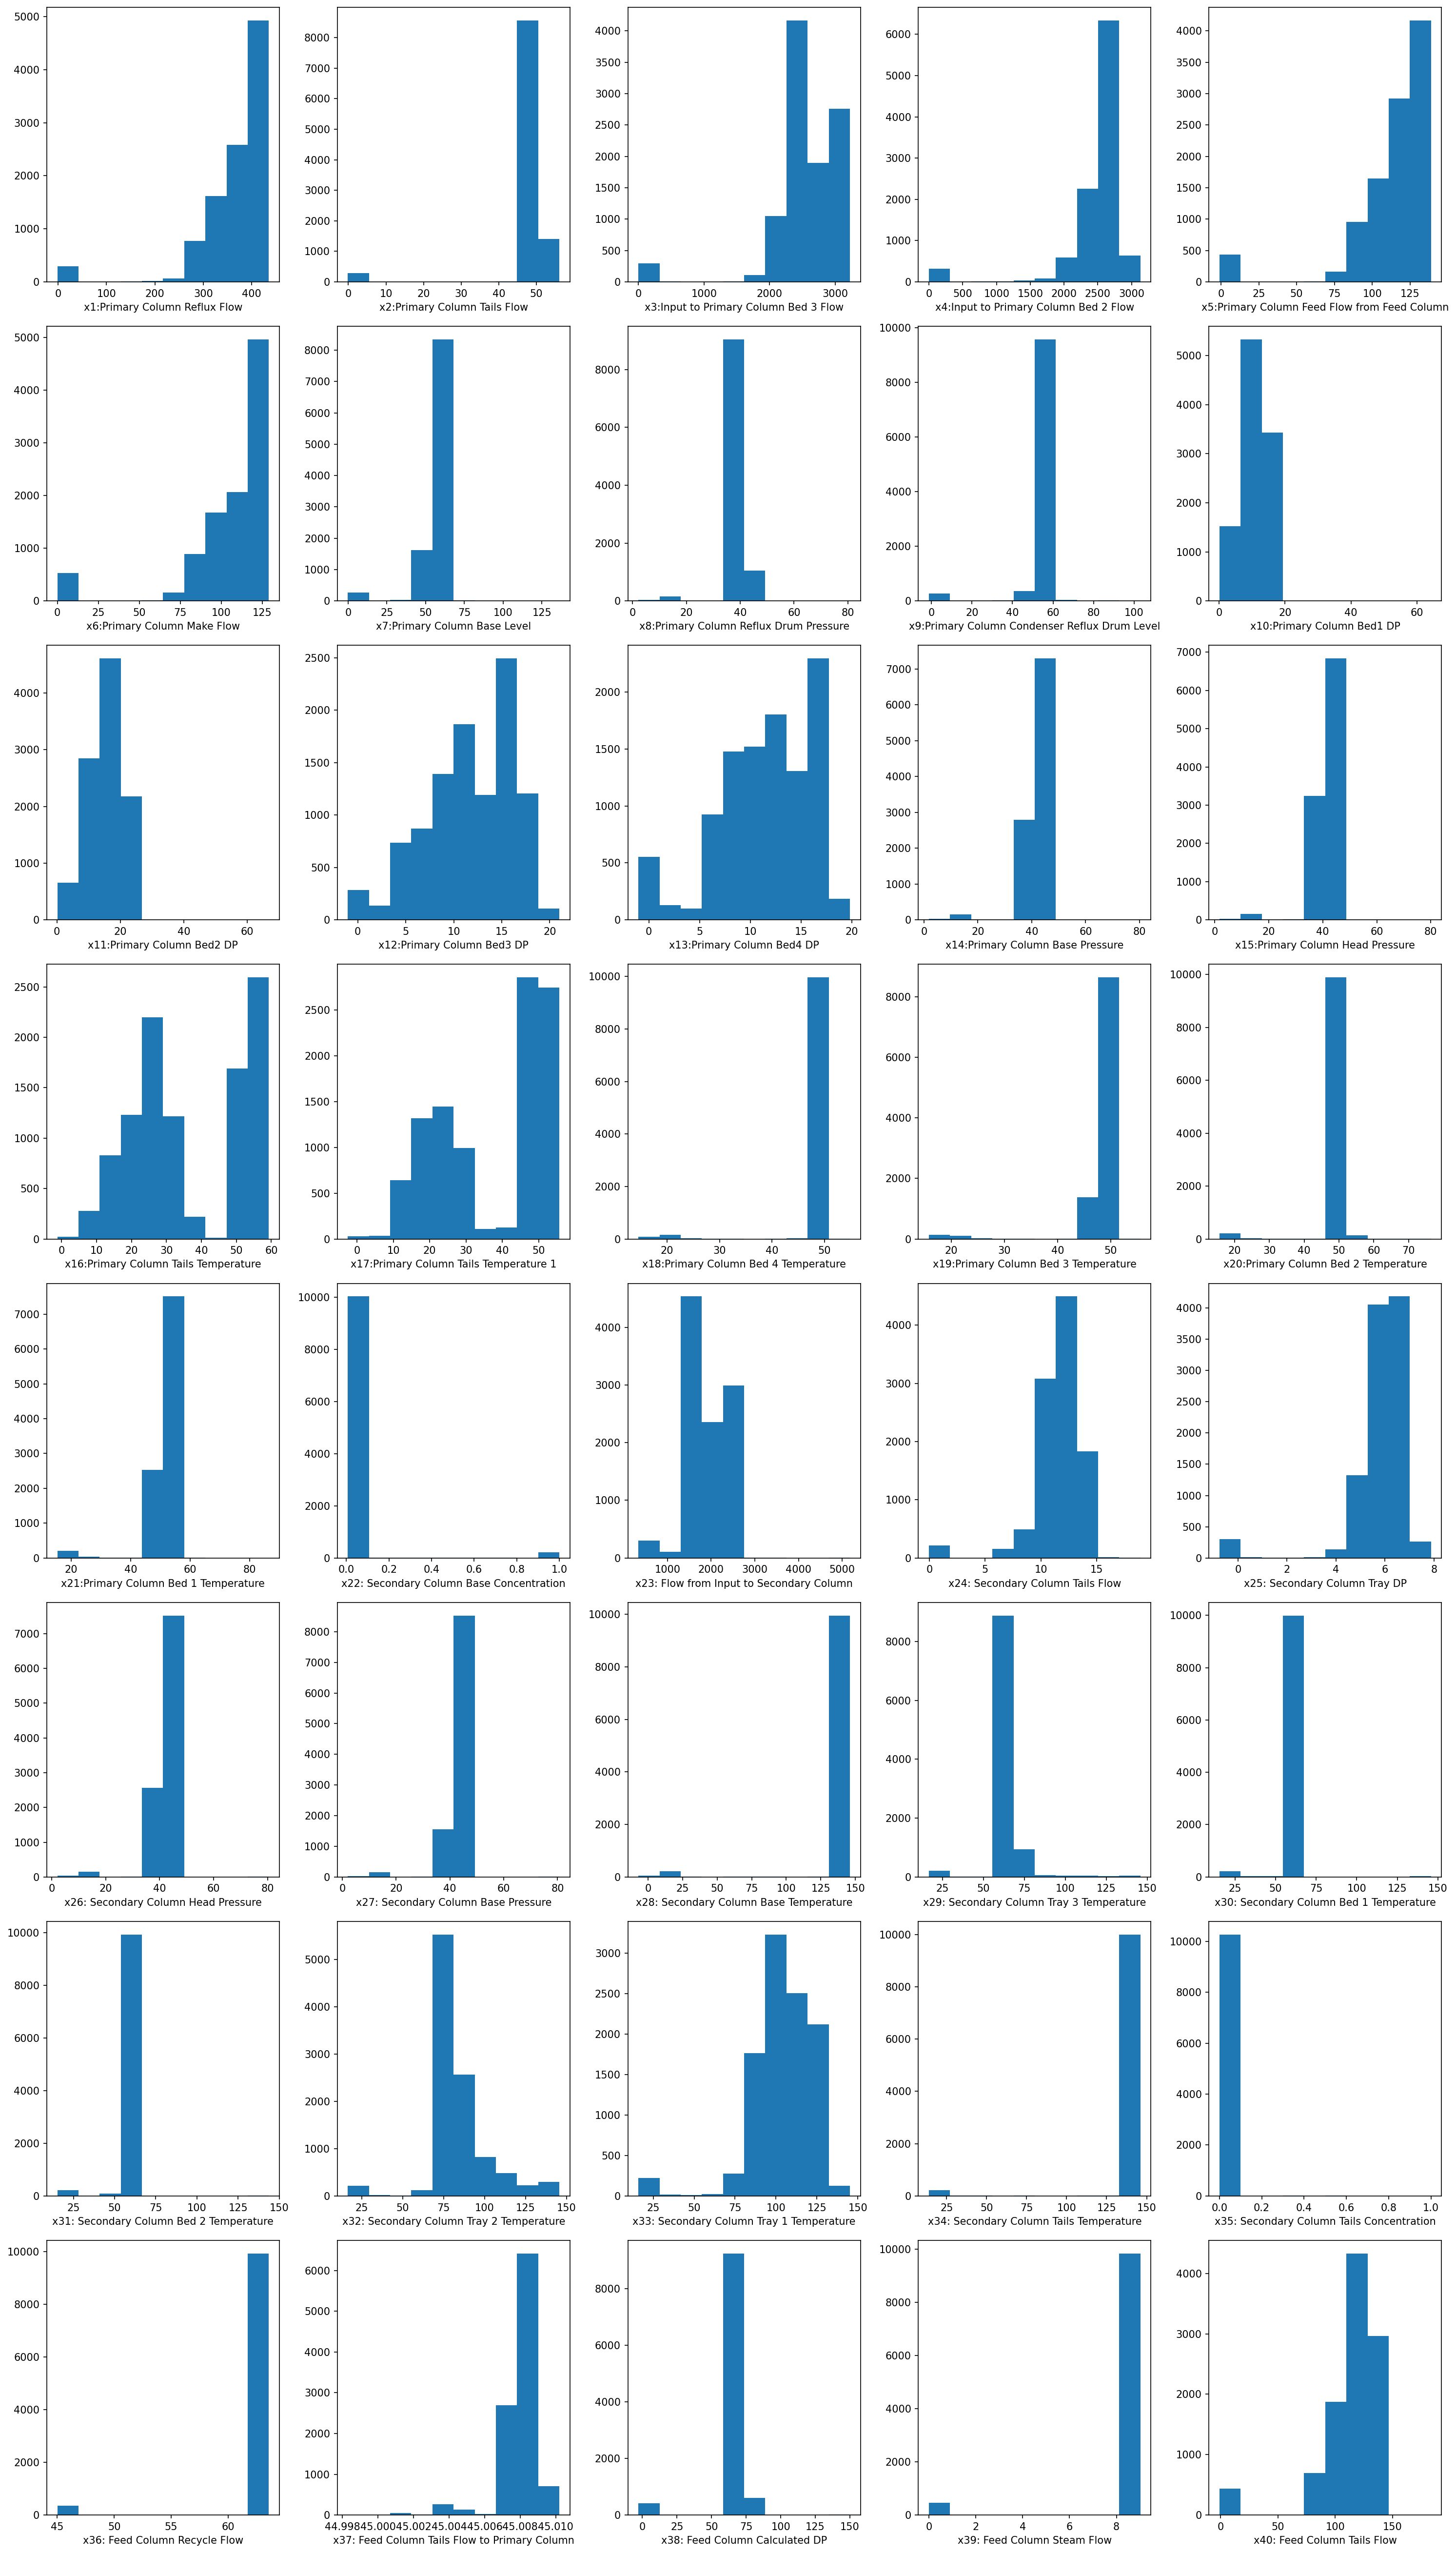

In [3]:
fig, axes = plt.subplots(8, 5, figsize = (20, 35), dpi = 150)
axes = axes.ravel()

col_names = df.columns[1:-5] # Extract the names of columns

for i, col in enumerate(col_names): # We know that the length of col_names is 40 such that i will iterate from 0 to 39
    axes[i].hist(X[:, i]) # Plot the histogram of i-th column of the X matrix
    axes[i].set_xlabel(col) # Write the name of column below the x-axis
    
plt.tight_layout() # Makes the plot look nicer

**Name a feature that is approximately normally distributed.**

You may use visual inspection to answer the following questions.

- x10
- x11
- x24
- x25
- x33
- etc.

**Name a feature that is approximately bimodally distributed.**

- x3
- x12
- x16
- x17
- etc.

**Name a feature that has significant outliers.**

- x1
- x2
- x3
- x4
- x5
- etc.

## Feature Scaling

**Down-sample the dataset by selecting every 10th data point.**

In [4]:
X_down = X[::10]
y_down = y[::10]

**Do a train/test split with `test_size=0.3`.**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_down, y_down, test_size = 0.3)

**Use the standard scaler and make the standardized dataset.**

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
# X_train_scaled = scaler.fit_transform(X_train) : fit_transform method does fit and transform at once and returns the scaled data
X_test_scaled = scaler.transform(X_test)

**Build a KRR model on the Dow dataset with and without scaling.**

Set $\gamma$=0.01 and $\alpha$=0.01.

In [7]:
from sklearn.kernel_ridge import KernelRidge

krr = KernelRidge(gamma = 0.01, kernel = 'rbf', alpha = 0.01)

krr.fit(X_train, y_train)
r2_wo_scaling = krr.score(X_test, y_test)

krr.fit(X_train_scaled, y_train)
r2_w_scaling = krr.score(X_test_scaled, y_test)

**Compare the $r^2$ score on the test set of the two approaches.**

In [8]:
print('r2 score before scaling: {}'.format(r2_wo_scaling))
print('r2 score after scaling: {}'.format(r2_w_scaling))

r2 score before scaling: -6.2751275088186995
r2 score after scaling: 0.8093489984542201


## LASSO Regression

**Note**  
Technically, we cannot scale the `X` matrix before doing `GridSearchCV`, which is the same issue we have faced in the last assignment. We do cross-validation during `GridSearchCV` (which is 3 different train/test split) such that scaling before `GridSearchCV` will cause data leakage. Data leakage basically means that partial or entire information of the test set leaks into the training set. In this case, we need means and standard deviations of features to scale the matrix. If we include the test set during scaling, the means and standard deviations will include the test data points, which we refer to as data leakage.  

Same as last week, we will accept the answer simply following the instructions. However, you may want to think about why scaling before `GridSearchCV` is improper. The ideal way to approach this problem is to construct a `pipeline`. I know we did not cover the concept of the `pipeline`. You can consider this as a wrapper function that we covered during the autograd package. You can build a workflow by plugging multiple functions or models into a single `pipeline` model. Then, this `pipeline` will perform each function or model step by step for each train/test set or cross-validation. I will show a brief way to solve this problem using the `pipeline` in this solution. Since handling a `pipeline` model is beyond the scope of this course, we will not ask you to use a `pipeline` in the mid-term exam or the following assignments.


**Scale the feature matrix using the standard scaler.**

In [9]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_down)

**Shuffle the data.**

In [10]:
from sklearn.utils import shuffle

X_scaled_shuffle, y_shuffle = shuffle(X_scaled, y_down)

**Build a `GridSearchCV` model that optimizes the hyperparameters of a LASSO model.**

Search over $\alpha \in$ [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1].

Use 3-fold cross-validation.

In [11]:
# Useful command if you want to get rid of red boxes

import warnings
warnings.simplefilter('ignore')

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
param_grid = {'alpha': alphas}

LASSO = Lasso()

lasso_search = GridSearchCV(LASSO, param_grid, cv = 3)
lasso_search.fit(X_scaled_shuffle, y_shuffle)

GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]})

**Evaluate the performance of the best model.**

Print the optimized $\alpha$ as well as the $r^2$ score.

In [13]:
print('Optimal alpha: {}'.format(lasso_search.best_estimator_.alpha))
print('Best r2 score: {}'.format(lasso_search.best_score_))

Optimal alpha: 0.01
Best r2 score: 0.6841431672710189


**Describe which features (if any) were dropped.**

Dropped features have coefficients equal to zero.

In [14]:
coeffs = lasso_search.best_estimator_.coef_
zero_coeffs = col_names[coeffs == 0]
print(zero_coeffs)

Index(['x1:Primary Column Reflux Flow', 'x2:Primary Column Tails Flow',
       'x3:Input to Primary Column Bed 3 Flow',
       'x8:Primary Column Reflux Drum Pressure', 'x12:Primary Column Bed3 DP',
       'x13:Primary Column Bed4 DP', 'x14:Primary Column Base Pressure',
       'x15:Primary Column Head Pressure',
       'x18:Primary Column Bed 4 Temperature',
       'x19:Primary Column Bed 3 Temperature',
       'x20:Primary Column Bed 2 Temperature',
       'x21:Primary Column Bed 1 Temperature',
       'x26: Secondary Column Head Pressure',
       'x27: Secondary Column Base Pressure',
       'x29: Secondary Column Tray 3 Temperature',
       'x30: Secondary Column Bed 1 Temperature',
       'x31: Secondary Column Bed 2 Temperature',
       'x33: Secondary Column Tray 1 Temperature',
       'x34: Secondary Column Tails Temperature',
       'x35: Secondary Column Tails Concentration',
       'x38: Feed Column Calculated DP', 'x40: Feed Column Tails Flow'],
      dtype='object')


**Solution using the `pipeline`**

In [15]:
from sklearn.pipeline import Pipeline

X_down_shuffle, y_down_shuffle = shuffle(X_down, y_down) # Shuffle unscaled X_down and y_down

pipeline = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso())]) # We made a pipeline of two steps: 1. do standard scaling 2. train a LASSO model
param_grid = dict(lasso__alpha = alphas) # Set a parameter grid for the LASSO model (I know the naming is weird)

pipeline_search = GridSearchCV(pipeline, param_grid, cv = 3)
pipeline_search.fit(X_down_shuffle, y_down_shuffle)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]})

In [16]:
print('Optimal alpha: {}'.format(pipeline_search.best_params_))
print('Best r2 score: {}'.format(pipeline_search.best_score_))

Optimal alpha: {'lasso__alpha': 0.01}
Best r2 score: 0.6835253453614486


In [17]:
coeffs_pipeline = pipeline_search.best_estimator_['lasso'].coef_
zero_coeffs_pipeline = col_names[coeffs_pipeline == 0]
print(zero_coeffs_pipeline)

Index(['x1:Primary Column Reflux Flow', 'x2:Primary Column Tails Flow',
       'x3:Input to Primary Column Bed 3 Flow',
       'x8:Primary Column Reflux Drum Pressure', 'x12:Primary Column Bed3 DP',
       'x13:Primary Column Bed4 DP', 'x14:Primary Column Base Pressure',
       'x15:Primary Column Head Pressure',
       'x18:Primary Column Bed 4 Temperature',
       'x19:Primary Column Bed 3 Temperature',
       'x20:Primary Column Bed 2 Temperature',
       'x21:Primary Column Bed 1 Temperature',
       'x26: Secondary Column Head Pressure',
       'x27: Secondary Column Base Pressure',
       'x29: Secondary Column Tray 3 Temperature',
       'x30: Secondary Column Bed 1 Temperature',
       'x31: Secondary Column Bed 2 Temperature',
       'x33: Secondary Column Tray 1 Temperature',
       'x34: Secondary Column Tails Temperature',
       'x35: Secondary Column Tails Concentration',
       'x38: Feed Column Calculated DP', 'x40: Feed Column Tails Flow'],
      dtype='object')


## Principal Component and Forward Selection

**Use the eigenvalues of the covariance matrix to perform PCA on the scaled feature matrix.**

*Hint: You can check your answers using PCA from `scikit-learn` or other packages if you want*

In [18]:
from scipy.linalg import eigvals, eig

corr = np.corrcoef(X_down.T) # You can use either the X_down or the original X. Here, I will use the X_down for the sake of simplicity.
# corr = np.cov(X_scaled.T)
PCvals, PCvecs = eig(corr)
PC_projection = np.dot(X_scaled, PCvecs)

**Determine which principal component of the dataset is most linearly correlated with the impurity concentration.**

Print the order of the principal component (e.g. 5th PC) and its $r^2$ score.

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

r2List = []

for i in range(PC_projection.shape[1]):
    lr.fit(PC_projection[:, i:i+1], y_down)
    r2 = lr.score(PC_projection[:, i:i+1], y_down)
    r2List.append((r2, i))
    
r2List.sort()
r2max = r2List[-1][0]
PCmax = r2List[-1][1]

print('Most linearly correlated PC: {}th PC'.format(PCmax + 1))
print('Maximum r2 score: {}'.format(r2max))

Most linearly correlated PC: 2th PC
Maximum r2 score: 0.22304172376486353


**Determine which original feature of the dataset is most linearly correlated to the impurity concentration.**

Print the name of the feature and its $r^2$ score.

In [20]:
r2List = []

for i in range(X_scaled.shape[1]):
    lr.fit(X_scaled[:, i:i+1], y_down)
    r2 = lr.score(X_scaled[:, i:i+1], y_down)
    r2List.append((r2, i))
    
r2List.sort()
r2max = r2List[-1][0]
featuremax = r2List[-1][1]

print('Most lienarly correlated feature: {}'.format(col_names[featuremax]))
print('Maximum r2 score: {}'.format(r2max))

Most lienarly correlated feature: x10:Primary Column Bed1 DP
Maximum r2 score: 0.5436900094204682
